# Generating patient sub-networks

Here we are taking published RNA-seq datasets from three publications:

* AML patients - *Gilliland et al. 2013*
* ALL patients - *Agraz-Doblas et al. 2019*
* FBM cells - *O’byrne et al. 2019*

The approach we use is to filter the MLL-AF4 KD RNA-seq data we use for constructing an MLL-AF4 GRN, and filtering this by expressed genes on a patient-to-patient basis. We then rerun the GRN workflow, as in 01_Build_Network.ipynb.

## Setup

In [2]:
library(tidyverse)
library(GenomicRanges)
library(annotables)
library(GeneNetworkBuilder)

## Functions

In [3]:
# Prepare gene table for lookup joins
hg38.lookup <- grch38 %>%
    mutate(entrez = as.character(entrez)) %>%
    select(ensgene, entrez, symbol) %>%
    filter(entrez != "<NA>")

# Importing datasets for MLL-AF4 GRN workflow

In [4]:
Chip.filePath <- "../data/ChIPseq_tables/SEM_MLL-AF4_binding_table.txt"
binding.table <- read_tsv(Chip.filePath) %>% # cc specifies 2 columns as character!
    as.data.frame()

Parsed with column specification:
cols(
  from = col_double(),
  to = col_double()
)



In [5]:
deg.filePath <- "../data/RNAseq_tables_hg38/MLLAF4_KD/contrast_SIMM_vs_SIMA6_counts.tsv"
de.genes <- read_tsv(deg.filePath) %>%
    select(Geneid, logFC, FDR)

Parsed with column specification:
cols(
  Geneid = col_character(),
  Length = col_double(),
  logFC = col_double(),
  logCPM = col_double(),
  LR = col_double(),
  PValue = col_double(),
  FDR = col_double(),
  SIMA6_1 = col_double(),
  SIMA6_2 = col_double(),
  SIMA6_3 = col_double(),
  SIMM_1 = col_double(),
  SIMM_2 = col_double(),
  SIMM_3 = col_double()
)



In [6]:
data("hs.interactionmap") # The basis for all network formation

# Importing patient datasets

log transforming as necessary


In [7]:
# Expression data
df.laml <- suppressMessages(read_tsv("../Patient integration update - Nov2019/data/LAML_RNAseq_log2tpm.tsv")) %>%
    column_to_rownames("GeneID") %>%
    filter(rowSums(.) > (ncol(.) * 0.05))
df.men <- suppressMessages(read_csv("../Patient integration update - Nov2019/data/Men_TPM.csv")) %>%
    column_to_rownames("GeneID") %>%
    filter(rowSums(.) > (ncol(.) * 0.05))
df.ox_fbm <- suppressMessages(read_csv("../Patient integration update - Nov2019/data/OX_FBM_TPM.csv")) %>%
    column_to_rownames("GeneID") %>%
    filter(rowSums(.) > (ncol(.) * 0.05))

# Log transform
df.men <- log2(df.men + 1)
df.ox_fbm <- log2(df.ox_fbm + 1)

# Annotation tables
ann.laml <- suppressMessages(read_tsv("../Patient integration update - Nov2019/data/LAML_RNAseq_anno.tsv"))
ann.men <- suppressMessages(read_csv("../Patient integration update - Nov2019/data/Men_anno.csv"))
ann.ox_fbm <- suppressMessages(read_csv("../Patient integration update - Nov2019/data/OX_FBM_anno.csv"))

# Combining expression tables
df.list <- list(
    LAML = df.laml,
    Menendez = df.men,
    OX_FBM = df.ox_fbm
)


Note - due to an update to hg19, the official gene name MLL has changed to KMT2A. This occasionally results in conflicts between datasets that were generated using different versions of hg19 (or hg38). Here we are ensuring the name is consistent across datasets.

In [8]:
rownames(df.list[[1]])[rownames(df.list[[1]]) == "MLL"] <- "KMT2A"
rownames(df.list[[2]])[rownames(df.list[[2]]) == "MLL"] <- "KMT2A"
rownames(df.list[[3]])[rownames(df.list[[3]]) == "MLL"] <- "KMT2A"

In [9]:
# Melt and combine datasets into a single table

x1 <- data.frame(group="AML", reshape2::melt(df.list[[1]], variable.name = "sample", value.name = "log2_TPM"))
x2 <- data.frame(group="ALL", reshape2::melt(df.list[[2]], variable.name = "sample", value.name = "log2_TPM"))
x3 <- data.frame(group="FBM", reshape2::melt(df.list[[3]], variable.name = "sample", value.name = "log2_TPM"))
x <- rbind(x1, x2, x3)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



# Establish expressed genes across samples

We first establish the mean log2 TPM value for each dataset.

In [10]:
med_AML <- mean(x1$log2_TPM)
med_ALL <- mean(x2$log2_TPM)
med_FBM <- mean(x3$log2_TPM)

med_AML 
med_ALL
med_FBM 


[1] 3.75165

[1] 1.968193

[1] 1.651105

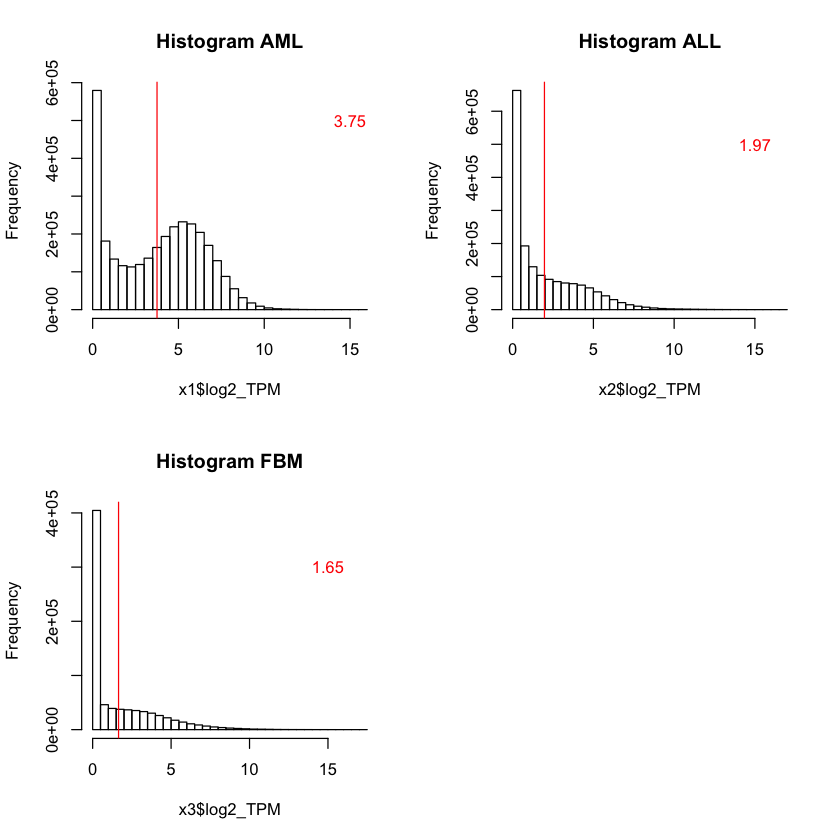

In [11]:
par(mfrow = c(2,2), bg="white")
hist(x1$log2_TPM, breaks=50, main = "Histogram AML")
text(x=15, y=500000, labels=round(med_AML, 2), col="red")
abline(v = med_AML, col="red")

hist(x2$log2_TPM, breaks=50, main = "Histogram ALL")
text(x=15, y=500000, labels=round(med_ALL, 2), col="red")
abline(v = med_ALL, col="red")

hist(x3$log2_TPM, breaks=50, main = "Histogram FBM")
text(x=15, y=300000, labels=round(med_FBM, 2), col="red")
abline(v = med_FBM, col="red")

In [12]:
# Convert expression data into boolean matrix (T is greater than mean)

df.list[[1]] <- df.list[[1]] > mean(unlist(df.list[[1]]))
df.list[[2]] <- df.list[[2]] > mean(unlist(df.list[[2]]))
df.list[[3]] <- df.list[[3]] > mean(unlist(df.list[[3]]))

head(df.list[[1]])

,TCGA.AB.2803,TCGA.AB.2807,TCGA.AB.2963,TCGA.AB.2826,TCGA.AB.2867,TCGA.AB.2818,TCGA.AB.2808,TCGA.AB.2853,TCGA.AB.2854,TCGA.AB.2822,⋯,TCGA.AB.2949,TCGA.AB.2981,TCGA.AB.2999,TCGA.AB.2896,TCGA.AB.2952,TCGA.AB.2920,TCGA.AB.2841,TCGA.AB.2811,TCGA.AB.2979,TCGA.AB.2977
A1BG-AS,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,⋯,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
A1BG,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,⋯,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
A2LD1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
A2ML1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
A2M,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
A4GALT,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE


In [13]:
# Extract expressed genes for each sample individually 

gene.list.1 <- list()
x <- 1
for(i in 1:ncol(df.list[[x]])){
    gene.list.1[[i]] <- rownames(df.list[[x]])[df.list[[x]][,i]]
    names(gene.list.1)[i] <- colnames(df.list[[x]])[i]
}

gene.list.2 <- list()
x <- 2
for(i in 1:ncol(df.list[[x]])){
    gene.list.2[[i]] <- rownames(df.list[[x]])[df.list[[x]][,i]]
    names(gene.list.2)[i] <- colnames(df.list[[x]])[i]
}

gene.list.3 <- list()
x <- 3
for(i in 1:ncol(df.list[[x]])){
    gene.list.3[[i]] <- rownames(df.list[[x]])[df.list[[x]][,i]]
    names(gene.list.3)[i] <- colnames(df.list[[x]])[i]
}


# Filter MLL-AF4 KD RNA-seq by extracted gene lists, to create a table for each patient.

In [20]:

exprs.1 <- lapply(gene.list.1, function(g){
    de.genes %>%
        filter(Geneid %in% g) %>%
        inner_join(hg38.lookup, by = c("Geneid" = "symbol")) %>% # Convert to entrez
        select(entrez, logFC, P.Value = FDR, symbol = Geneid) %>%
        distinct(entrez, .keep_all = T) %>%
        as.data.frame()
})

exprs.2 <- lapply(gene.list.2, function(g){
    de.genes %>%
        filter(Geneid %in% g) %>%
        inner_join(hg38.lookup, by = c("Geneid" = "symbol")) %>% # Convert to entrez
        select(entrez, logFC, P.Value = FDR, symbol = Geneid) %>%
        distinct(entrez, .keep_all = T) %>%
        as.data.frame()
})

exprs.3 <- lapply(gene.list.3, function(g){
    de.genes %>%
        filter(Geneid %in% g) %>%
        inner_join(hg38.lookup, by = c("Geneid" = "symbol")) %>% # Convert to entrez
        select(entrez, logFC, P.Value = FDR, symbol = Geneid) %>%
        distinct(entrez, .keep_all = T) %>%
        as.data.frame()
})


In [21]:
exprs.1$TCGA.AB.2805 %>% head
exprs.1$TCGA.AB.2815 %>% head

,entrez,logFC,P.Value,symbol
,<chr>,<dbl>,<dbl>,<chr>
1,8842,-1.918198,3.606216e-275,PROM1
2,132864,-1.958025,1.677680e-151,CPEB2
3,2078,-1.280531,3.675610e-117,ERG
4,3206,-1.516995,5.300073e-98,HOXA10
5,10320,-1.280817,2.452852e-92,IKZF1
6,55701,1.659394,4.189164e-88,ARHGEF40


,entrez,logFC,P.Value,symbol
,<chr>,<dbl>,<dbl>,<chr>
1,8842,-1.918198,3.606216e-275,PROM1
2,132864,-1.958025,1.677680e-151,CPEB2
3,2078,-1.280531,3.675610e-117,ERG
4,10320,-1.280817,2.452852e-92,IKZF1
5,55701,1.659394,4.189164e-88,ARHGEF40
6,4130,2.341169,4.564343e-85,MAP1A


# Generate networks for each patient

First we establish the underlying network using MLL-AF4 ChIPseq

In [22]:
# Build underlying network with MLL-AF4 ChIPseq and hs.interactionmap

net <- buildNetwork(
    TFbindingTable = as.data.frame(binding.table[,-3]),
    interactionmap = hs.interactionmap,
    level = 1
)

Next, we loop through the filtered MLL-AF4 RNA-seq tables, where each table is specific to a patient, and create a filtered network.

In [ ]:
filt.net.1 <- lapply(exprs.1, function(exprs){
    filtered.net <- filterNetwork(
        rootgene = "4297", # MLL
        sifNetwork = net,
        exprsData = exprs,
        mergeBy = "entrez",
        tolerance = 2,
        cutoffPVal = 0.05,
        cutoffLFC = 0.001
    )
})
filt.net.2 <- lapply(exprs.2, function(exprs){
    filtered.net <- filterNetwork(
        rootgene = "4297", # MLL
        sifNetwork = net,
        exprsData = exprs,
        mergeBy = "entrez",
        tolerance = 2,
        cutoffPVal = 0.05,
        cutoffLFC = 0.001
    )
})
filt.net.3 <- lapply(exprs.3, function(exprs){
    filtered.net <- filterNetwork(
        rootgene = "4297", # MLL
        sifNetwork = net,
        exprsData = exprs,
        mergeBy = "entrez",
        tolerance = 2,
        cutoffPVal = 0.05,
        cutoffLFC = 0.001
    )
})


Then we write the new networks to file

In [27]:
filt.net <- filt.net.1
pre_n <- "Melnick"
for(i in 1:length(filt.net)){
    grn <- filt.net[[i]]
    n1 <- paste0("./", pre_n, "/PatientSubnet_", pre_n, "_", names(filt.net)[i], "_edges.txt")
    n2 <- paste0("./", pre_n, "/PatientSubnet_", pre_n, "_", names(filt.net)[i], "_nodes.txt")
    
    edges <- grn %>% select(from, to)
    nodes <- edges %>% 
        gather(node_type, entrez) %>% 
        distinct(entrez) %>% 
        inner_join(hg38.lookup, by = "entrez") %>% 
        select(entrez, symbol)
    
    write_tsv(edges, n1)
    write_tsv(nodes, n2)
}

###

filt.net <- filt.net.2
pre_n <- "LAML"
for(i in 1:length(filt.net)){
    grn <- filt.net[[i]]
    n1 <- paste0("./", pre_n, "/PatientSubnet_", pre_n, "_", names(filt.net)[i], "_edges.txt")
    n2 <- paste0("./", pre_n, "/PatientSubnet_", pre_n, "_", names(filt.net)[i], "_nodes.txt")
    
    edges <- grn %>% select(from, to)
    nodes <- edges %>% 
        gather(node_type, entrez) %>% 
        distinct(entrez) %>% 
        inner_join(hg38.lookup, by = "entrez") %>% 
        select(entrez, symbol)
    
    write_tsv(edges, n1)
    write_tsv(nodes, n2)
}

###

filt.net <- filt.net.3
pre_n <- "Menendez"
for(i in 1:length(filt.net)){
    grn <- filt.net[[i]]
    n1 <- paste0("./", pre_n, "/PatientSubnet_", pre_n, "_", names(filt.net)[i], "_edges.txt")
    n2 <- paste0("./", pre_n, "/PatientSubnet_", pre_n, "_", names(filt.net)[i], "_nodes.txt")
    
    edges <- grn %>% select(from, to)
    nodes <- edges %>% 
        gather(node_type, entrez) %>% 
        distinct(entrez) %>% 
        inner_join(hg38.lookup, by = "entrez") %>% 
        select(entrez, symbol)
    
    write_tsv(edges, n1)
    write_tsv(nodes, n2)
}


# Binary matrix
The sub-networks can also be described as a binary matrix.

We take the binary matrices from earlier in the script, and combine them. The sample IDs (column names) can later be used to extract samples from different databases.

In [37]:
df.list2 <- lapply(df.list, function(x) x %>% data.frame() %>% rownames_to_column("symbol"))
df.list3 <- lapply(df.list2, function(x) left_join(nodes, x) %>% select(-entrez))
                   
binary.matrix <- df.list3[[1]] %>%
    left_join(df.list3[[2]]) %>%
    left_join(df.list3[[3]]) %>%
    mutate_all(function(x) replace(x, is.na(x), F)) %>%
    distinct(symbol, .keep_all = T) %>%
    column_to_rownames("symbol")


Joining, by = "symbol"

Joining, by = "symbol"

Joining, by = "symbol"

Joining, by = "symbol"



In [39]:
binary.matrix[1:5,1:5]

,GSM856281,GSM856282,GSM856283,GSM856284,GSM856285
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
EGR1,TRUE,TRUE,TRUE,TRUE,TRUE
FOSL2,TRUE,TRUE,TRUE,TRUE,FALSE
ARNT,TRUE,TRUE,TRUE,TRUE,FALSE
MYC,TRUE,TRUE,TRUE,TRUE,TRUE
RREB1,TRUE,TRUE,TRUE,TRUE,TRUE


In [64]:
write_tsv(rownames_to_column(binary.matrix, "Geneid"), "Patient_Binary_Matrix.tsv")